In [1]:
import operator
import os
from typing import Annotated, Any
from pathlib import Path

import yaml
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage

In [2]:
MODEL_NAME = "llama3.1"

In [3]:
# Load environment variables
load_dotenv(".env")

# Verify API key is available
api_key = os.getenv("SELFHOSTED_API_KEY")
api_url = os.getenv("SELFHOSTED_API_URL")

if not api_url:
    api_url = "http://localhost:8000/v1"
    
if not api_key:
    raise ValueError("API_KEY not found in environment variables. Please check your .env file.")
print("✅ Environment variables loaded successfully")

✅ Environment variables loaded successfully


In [4]:
PROMPT_DIR = Path("configs/prompt/schema_construction")

prompt_names = ["problem_definer_helper", "problem_definer", "schema_refiner", "schema_assessment", "schema_generator"]

prompts = {}
for prompt_config_file in prompt_names:
    with open(f"{PROMPT_DIR}/{prompt_config_file}.yaml", "r") as f:
        prompt_config = yaml.safe_load(f)
    prompts.update(prompt_config)

In [5]:
# State management for the multi-agent system
class AgentState(TypedDict):
    """State shared across all agents in the schema processing workflow."""
    messages: Annotated[list, add_messages]  # Chat messages between agents
    user_input: str  # Original user request
    problem_help: str | None # output from problem definer helper agent
    user_feedback: str | None # feedback for the problem definer helper agent
    problem_definition: str | None # problem definition
    current_schema: dict[str, Any] | None  # Current schema being processed
    refinement_rounds: Annotated[int, operator.add]  # Number of refinement iterations
    assessment_result: dict[str, Any] | None  # Quality assessment results

In [ ]:
class ProblemDefinerHelperAgent:
    """Routes user requests to the appropriate processing agent."""
    
    def __init__(self, llm) -> None:
        self.parser = StrOutputParser()
        prompt = PromptTemplate.from_template(prompts["problem_definer_helper_prompt"])
        self.chain = prompt | llm

    def __call__(self, state: AgentState) -> dict[str, Any]:
        response = self.chain.invoke({"user_input": state["user_input"]})
        parsed_response = self.parser.parse(response.content)
        return {"messages": [response], "problem_help": parsed_response}
    
class ProblemDefinerAgent:
    """Generates new schemas from natural language descriptions."""
    
    def __init__(self, llm) -> None:
        self.parser = StrOutputParser()
        prompt = PromptTemplate.from_template(prompts["problem_definer_prompt"])
        self.chain = prompt | llm

    def __call__(self, state: AgentState) -> dict[str, Any]:
        user_input = state["user_input"]
        problem_help = state["problem_help"]
        user_feedback = state["user_feedback"]

        response = self.chain.invoke({"user_input": user_input, "problem_help": problem_help, "user_feedback": user_feedback})
        parsed_response = self.parser.parse(response.content)
        
        update_dict = {"messages": [response], "problem_definition": parsed_response}
        return update_dict


class SchemaGeneratorAgent:
    """Generates new schemas from natural language descriptions."""
    
    def __init__(self, llm) -> None:
        self.parser = JsonOutputParser()
        prompt = PromptTemplate.from_template(prompts["schema_generator_prompt"])
        self.chain = prompt | llm

    def __call__(self, state: AgentState) -> dict[str, Any]:
        user_input = state["user_input"]
        problem_help = state["problem_help"]
        user_feedback = state["user_feedback"]
        problem_definition = state["problem_definition"]

        response = self.chain.invoke({"user_input": user_input, "problem_help": problem_help, "user_feedback": user_feedback, "problem_definition": problem_definition})
        parsed_response = self.parser.parse(response.content)
        
        update_dict = {"messages": [response]}
        if parsed_response.get("is_generated", False):
            update_dict["current_schema"] = parsed_response.get("schema")
        
        return update_dict
    
class SchemaAssessmentAgent:
    """Evaluates schema quality against multiple criteria."""
    
    def __init__(self, llm) -> None:
        self.parser = JsonOutputParser()
        prompt = PromptTemplate.from_template(prompts["schema_assessment_prompt"])
        self.chain = prompt | llm

    def __call__(self, state: AgentState) -> dict[str, Any]:
        user_input = state["user_input"]
        problem_help = state["problem_help"]
        user_feedback = state["user_feedback"]
        problem_definition = state["problem_definition"]
        current_schema = state["current_schema"]


        response = self.chain.invoke({
            "user_input": user_input,
            "problem_help": problem_help,
            "user_feedback": user_feedback,
            "problem_definition": problem_definition,
            "current_schema": current_schema,
        })
        parsed_response = self.parser.parse(response.content)
        return {"messages": [response], "assessment_result": parsed_response}



class SchemaRefinerAgent:
    """Improves existing schemas based on quality criteria."""
    
    def __init__(self, llm) -> None:
        self.parser = JsonOutputParser()
        prompt = PromptTemplate.from_template(prompts["schema_refiner_prompt"])
        self.chain = prompt | llm

    def __call__(self, state: AgentState) -> dict[str, Any]:
        user_input = state["user_input"]
        problem_help = state["problem_help"]
        user_feedback = state["user_feedback"]
        problem_definition = state["problem_definition"]
        current_schema = state["current_schema"]
        assessment_result = state["assessment_result"]

        response = self.chain.invoke({
            "user_input": user_input,
            "problem_help": problem_help,
            "user_feedback": user_feedback,
            "problem_definition": problem_definition,
            "current_schema": current_schema,
            "assessment_result": assessment_result,
        })
        parsed_response = self.parser.parse(response.content)
        refinement_rounds = state.get("refinement_rounds", 0)
        update_dict = {"messages": [response], "refinement_rounds": refinement_rounds + 1}
        if parsed_response.get("is_refined", False):
            update_dict["current_schema"] = parsed_response.get("schema")
        return update_dict

# ============================================================================
# ROUTING FUNCTIONS
# ============================================================================


def route_after_assessment(state: AgentState) -> str:
    """Route to refiner if needs refinement and under max rounds, otherwise END."""
    assessment = state.get("assessment_result", {})
    refinement_rounds = state.get("refinement_rounds", 0)
    
    needs_refinement = assessment.get("needs_refinement", False)
    max_rounds_reached = refinement_rounds >= 5

    if refinement_rounds < 2:
        return "llm_schema_refiner"

    if needs_refinement and not max_rounds_reached:
        return "llm_schema_refiner"
    
    if max_rounds_reached:
        print("⚠️ Maximum refinement rounds (5) reached, ending process")
    
    return END

def human_feedback(state):
    feedback = input("Please provide feedback: ")
    return {"user_feedback": feedback, "messages": [HumanMessage(content=feedback)]}


class SchemaBuildingSystem:
    """Multi-agent system for generating, refining, and assessing legal schemas."""
    
    def __init__(self, llm) -> None:
        # Initialize all agents
        self.problem_definer_helper = ProblemDefinerHelperAgent(llm)
        self.problem_definer = ProblemDefinerAgent(llm)
        self.schema_generator = SchemaGeneratorAgent(llm)
        self.schema_assessment = SchemaAssessmentAgent(llm)
        self.schema_refiner = SchemaRefinerAgent(llm)

        # Build graph
        self.graph_builder = StateGraph(AgentState)

        # Add nodes
        self.graph_builder.add_node("llm_problem_definer_helper", self.problem_definer_helper)
        self.graph_builder.add_node("user_feedback_node", human_feedback)
        self.graph_builder.add_node("llm_problem_definer", self.problem_definer)
        self.graph_builder.add_node("llm_schema_generator", self.schema_generator)
        self.graph_builder.add_node("llm_schema_assessment", self.schema_assessment)
        self.graph_builder.add_node("llm_schema_refiner", self.schema_refiner)

        # Add edges
        self.graph_builder.add_edge(START, "llm_problem_definer_helper")
        self.graph_builder.add_edge("llm_problem_definer_helper", "user_feedback_node")
        self.graph_builder.add_edge("user_feedback_node", "llm_problem_definer")
        self.graph_builder.add_edge("llm_problem_definer", "llm_schema_generator")
        self.graph_builder.add_edge("llm_schema_generator", "llm_schema_assessment")
        self.graph_builder.add_edge("llm_schema_refiner", "llm_schema_assessment")
        

        # Route from assessment to refiner or END
        self.graph_builder.add_conditional_edges(
            "llm_schema_assessment",
            route_after_assessment,
            {
                "llm_schema_refiner": "llm_schema_refiner",
                END: END,
            },
        )

        self.graph = self.graph_builder.compile()

    def stream_graph_updates(
        self, user_input: str, current_schema: dict = None
    ) -> None:
        print("👤 Human:")
        print(user_input)
        print("-" * 50)
        """Process user input through the multi-agent workflow and display results."""
        initial_state = AgentState(
            messages=[],
            user_input=user_input,
            problem_help=None,
            user_feedback=None,
            problem_definition=None,
            current_schema=current_schema,
            refinement_rounds=0,
            assessment_result=None,
        )
        
        for event in self.graph.stream(initial_state):
            for value in event.values():
                # Get the full content from the latest message
                full_content = value["messages"][-1].content
                
                # Print with proper formatting to avoid truncation
                if value["messages"][-1].type == "human":
                    print("👤 Human:")
                else:
                    print("🤖 Assistant:")
                print(full_content)
                print("-" * 50)  

    def get_complete_results(
        self, user_input: str, current_schema: dict = None
    ) -> dict:
        """Process user input and return complete results without display truncation."""
        initial_state = AgentState(
            messages=[],
            user_input=user_input,
            problem_help=None,
            user_feedback=None,
            problem_definition=None,
            current_schema=current_schema,
            refinement_rounds=0,
            assessment_result=None,
        )
        
        # Run the complete workflow
        final_state = self.graph.invoke(initial_state)
        print(final_state)
        
        # Extract and return all results
        return {
            "final_schema": final_state.get("current_schema"),
            "assessment_result": final_state.get("assessment_result"),
            "refinement_rounds": final_state.get("refinement_rounds", 0),
            "all_messages": [msg.content for msg in final_state.get("messages", [])]
        }


In [7]:
# ============================================================================
# SYSTEM INITIALIZATION
# ============================================================================

# Configure the language model
llm = ChatOpenAI(
    model=MODEL_NAME,
    base_url=api_url,
    api_key=api_key,
    temperature=0.7,
    max_tokens=32_000,
    top_p=0.8,
    presence_penalty=1.5,
    extra_body={"top_k": 20, "chat_template_kwargs": {"enable_thinking": False}},
)

# Initialize the schema processing system with bug fixes
schema_system = SchemaBuildingSystem(llm)
print("✅ Schema processing system initialized successfully")
print("🔧 Bug fixes applied: KeyError 'assessment_result' resolved")

✅ Schema processing system initialized successfully
🔧 Bug fixes applied: KeyError 'assessment_result' resolved


🔄 System Workflow Diagram:


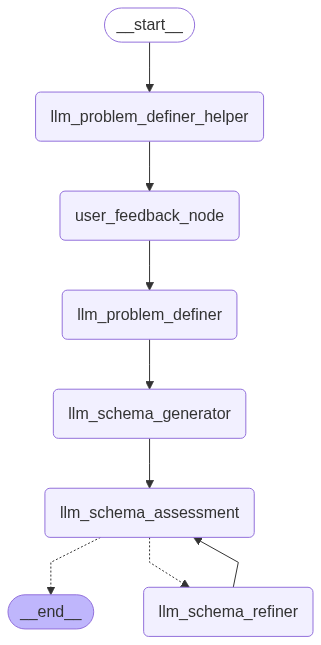

In [8]:
# ============================================================================
# SYSTEM WORKFLOW VISUALIZATION
# ============================================================================

# Display the system workflow graph
print("🔄 System Workflow Diagram:")
display(Image(schema_system.graph.get_graph().draw_mermaid_png()))

In [9]:
# ============================================================================
# DEMONSTRATION: SCHEMA GENERATION WORKFLOW
# ============================================================================

print("🚀 DEMO 1: Schema Generation for Legal Judgments")
print("=" * 60)

# Example 1: Generate schema from natural language description
schema_system.stream_graph_updates(
    "Generate schema to extract information from judgments about drug abuse, "
    "focus on the defendant's age and the amount of the fine."
)

print("\n" + "=" * 60)
print("✅ Schema generation demo completed!")


🚀 DEMO 1: Schema Generation for Legal Judgments
👤 Human:
Generate schema to extract information from judgments about drug abuse, focus on the defendant's age and the amount of the fine.
--------------------------------------------------
🤖 Assistant:
1. Just to confirm, you want to create a schema to analyze judgments related to drug abuse cases, focusing specifically on how the defendant's age affects the amount of the fine imposed. Is that correct?

2. Within the context of drug abuse cases, are you looking at possession, distribution, trafficking, or all types of drug-related offenses?

3. Idea: Would you like to explore if there's a correlation between the type of drug involved (e.g., marijuana, cocaine, heroin) and the severity of the fine imposed?

4. How do you envision categorizing the defendant's age? For example, would you look at minors (under 18), young adults (18-25), adults (26-50), or seniors (above 50)?

5. Are you interested in analyzing any other factors alongside the 

In [10]:
print("\n🚀 DEMO 2: Contract Schema Generation")
print("=" * 60)

# Example 2: Generate schema for contract analysis
schema_system.stream_graph_updates(
    "Generate schema to extract information from contracts, "
    "focus on contract value and parties involved."
)

print("\n" + "=" * 60)
print("✅ Contract schema demo completed!")



🚀 DEMO 2: Contract Schema Generation
👤 Human:
Generate schema to extract information from contracts, focus on contract value and parties involved.
--------------------------------------------------
🤖 Assistant:
1. Just to confirm, you're looking to create a schema to automatically extract data from contracts, with a focus on two main pieces of information: the monetary value of the contract and the parties involved (e.g., names of companies or individuals). Is that correct?

2. What type of contracts are you most interested in extracting information from (e.g., employment contracts, purchase agreements, lease agreements)?

3. Are there any specific clauses within these contracts that you'd like to prioritize extracting data from (e.g., payment terms, contract duration, termination conditions)?

4. Would you like to explore extracting additional metadata from these contracts, such as contract dates (effective date, expiration date), renewal terms, or dispute resolution processes?

5. H

In [ ]:
print("\n🚀 DEMO 5: Polish Personal Rights Violation")
print("=" * 60)

# Example 2: Generate schema for contract analysis
schema_system.stream_graph_updates(
    "Chciałbym zbadać sprawy o naruszenie dóbr osobistych. Chciałbym oceniać jak bardzo sprawca naruszył prawa osobiste."
)

print("\n" + "=" * 60)
print("✅ Contract schema demo completed!")